The problem is to predict if a project on donorschoose will not get fully funded within 60 days of posting. 
* This prediction is being done at the time of posting so you can only use data available to you at that time. 
* The data is a file that has one row for each project posted with a column for "date_posted" (the date the project was posted) and a column for "datefullyfunded" (the date the project was fully funded - assumption for this assignment is that all projects were fully funded eventually). 
* The data spans Jan 1, 2012 to Dec 31, 2013. 
* You should have your validation/test set be a rolling window of 6 months (which should give you three test sets). 
* The training sets should be everything from 1/1/12 to the beginning of the test set.

In [3]:
# basic dependencies
import numpy as np
import pandas as pd 
import seaborn as sns
import plotnine as p9
import matplotlib.pyplot as plt

# my own library of useful functions
import utils
import exploration as exp
import pipeline as pipe

In [4]:
projraw = utils.read_data('projects_2012_2013', 'csv')

In [7]:
projraw.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,...,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,...,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,f,4/14/13,5/2/13
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,...,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,t,4/7/12,4/18/12
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,...,Social Sciences,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,f,1/30/12,4/15/12
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,...,NaN,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,f,10/11/12,12/5/12
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,...,Literature & Writing,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,f,1/8/13,3/25/13


In [9]:
utils.find_cols_with_missing(projraw)

['school_ncesid',
 'school_metro',
 'school_district',
 'primary_focus_subject',
 'primary_focus_area',
 'secondary_focus_subject',
 'secondary_focus_area',
 'resource_type',
 'grade_level',
 'students_reached']

In [49]:
projraw.info()
# results of this make me want to not include secondary focus subject or area as a feature.
# Create boolean features for is_subject... etc. Then I can include nans. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124976 entries, 0 to 124975
Data columns (total 26 columns):
projectid                                 124976 non-null object
teacher_acctid                            124976 non-null object
schoolid                                  124976 non-null object
school_ncesid                             115743 non-null float64
school_latitude                           124976 non-null float64
school_longitude                          124976 non-null float64
school_city                               124976 non-null object
school_state                              124976 non-null object
school_metro                              109752 non-null object
school_district                           124804 non-null object
school_county                             124976 non-null object
school_charter                            124976 non-null object
school_magnet                             124976 non-null object
teacher_prefix                           

Here's what I'm going to do to this dataframe:
* convert date columns to dates
* convert t/f columns to actual booleans
* take the categorical variables and convert them to binary
* what should I normalize??? probably price, students reached

In [47]:
# convert categorical variables to binary
categorical_list = ['school_city',
                    'school_state',
                    'school_metro',
                    'primary_focus_subject',
                    'primary_focus_area',
                    'secondary_focus_subject',
                    'secondary_focus_area', 
                    'resource_type', 
                    'poverty_level',
                    'grade_level']
proj = utils.make_cat_dummy(projraw, categorical_list)

# replace string true/false with boolean values
proj = utils.convert_to_boolean(proj, ['school_charter',
                                       'school_magnet',
                                      'eligible_double_your_impact_match'], 't', 'f')

# convert date fields
proj['date_posted'] = pd.to_datetime(proj.date_posted) 
proj['datefullyfunded'] = pd.to_datetime(proj.datefullyfunded)

In [51]:
np.where(proj['school_charter'] == 'f', True, False)

array([ True,  True,  True, ...,  True,  True,  True])

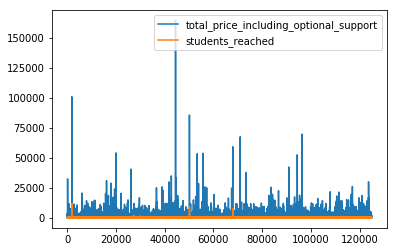

In [41]:
projraw[['total_price_including_optional_support', 'students_reached']].plot()